In [9]:
from utils import helpers  # helper functions

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, minmax_scale
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model_interfaces import base_model
import data, dice
import model as dice_model

In [28]:
# cf データ
cfs = pd.read_csv("csv/exp_genetic_extra_1000.csv")
# 入力データ
test_instance = pd.DataFrame.from_dict({'age': 29.0,
                'workclass': 'Private',
                'education': 'HS-grad',
                'marital_status': 'Married',
                'occupation': 'Blue-Collar',
                'race': 'White',
                'gender': 'Female',
                'hours_per_week': 38.0,
                'income': 0.159359}, orient='index').T
cfs = cfs.append(test_instance, ignore_index=True)

age_mad = np.median(cfs["age"])
hw_mad = np.median(cfs["hours_per_week"])
cfs.tail()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
996,0.0,Private,Some-college,Married,Blue-Collar,White,Male,38.0,0.083756
997,0.0,Private,HS-grad,Married,Service,White,Female,43.0,0.119945
998,29.0,Private,Masters,Separated,Service,White,Male,46.0,0.278272
999,17.0,Private,HS-grad,Married,White-Collar,White,Female,35.0,0.038536
1000,29.0,Private,HS-grad,Married,Blue-Collar,White,Female,38.0,0.159359


In [30]:
# カテゴリ変数のエンコード
#cfs = pd.get_dummies(cfs, columns=['workclass', 'education', 'marital_status', 'occupation', 'race', 'gender'])
#cfs.head()

In [31]:
# 連続変数のエンコード
cfs["age"] = minmax_scale(cfs["age"])
cfs["hours_per_week"] = minmax_scale(cfs["hours_per_week"])
cfs.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,0.559322,Private,Masters,Married,White-Collar,White,Female,0.561224,0.931921
1,0.813559,Private,Doctorate,Married,Professional,White,Female,0.489796,0.880581
2,0.559322,Private,Prof-school,Married,Other/Unknown,White,Female,0.540816,0.850054
3,0.745763,Private,Prof-school,Married,Sales,White,Male,0.571429,0.967227
4,0.474576,Self-Employed,Prof-school,Married,Professional,White,Female,0.418367,0.798187


In [32]:
# 入力データ, cfの前処理完了
test_instance = cfs.iloc[1000]
cfs = cfs.drop(cfs.index[[1000]])

In [48]:
proximity_loss_cont = np.abs(test_instance["age"] - cfs["age"])/age_mad + np.abs(test_instance["hours_per_week"] - cfs["hours_per_week"])/hw_mad
cat_list=['workclass', 'education', 'marital_status', 'occupation', 'race', 'gender']
proximity_loss_cat = np.zeros(7)
proximity_loss_cat_num = np.zeros(7)
for index, val in cfs.iterrows():
    loss = 0
    for cat in cat_list:
        if val[cat] != test_instance[cat]: loss += 1
    proximity_loss_cat[loss] += test_instance["income"] - val["income"]
    proximity_loss_cat_num[loss] += 1 

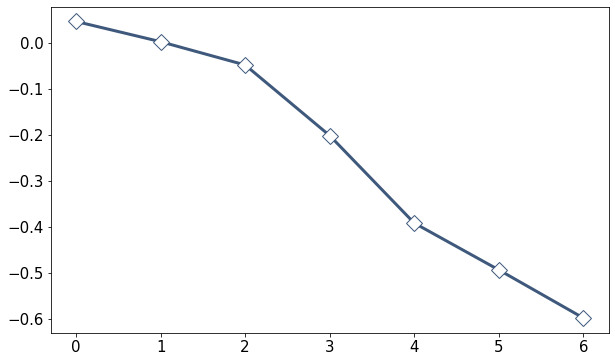

In [56]:
#proximity_loss = proximity_loss_cont + proximity_loss_cat
pred_list = [(proximity_loss_cat[i])/proximity_loss_cat_num[i] for i in range(len(proximity_loss_cat))]
plt.figure(figsize=(10, 6))
#plt.scatter(proximity_loss, cfs["income"], color="#3F597C")
plt.plot(range(7), pred_list, color="#3F597C", linewidth=3, marker="D", markersize=12 , markerfacecolor='white')
#plt.savefig("images/proximity_loss_yloss_tradeoff.png")
#plt.ylim(0.0,1.0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()